
$$\psi(x, t) = A \cdot e^{-\frac{(x - x_0)^2}{2\sigma^2}} \cdot e^{i(kx - \omega t)}$$

$$i \hbar \frac{{\partial \psi}}{{\partial t}} = -\frac{\hbar^2}{2m} (\frac{{\partial^2 \psi}}{{\partial x^2}} + \frac{{\partial^2 \psi}}{{\partial y^2}}) + V(x, y) \psi$$

In [97]:
import numpy as np
from scipy.sparse.linalg import spsolve
from scipy.sparse import csc_matrix
import matplotlib.pyplot as plt


hbar = 0.6582119514
m = 0.5109989461

L = 10.0
T = 100.0
dx, dt = 0.5, 0.5
N = int(L/dx) + 1
x0, y0 = 0.0, 0.0
x, y = np.meshgrid(np.linspace(-L/2, L/2, N), np.linspace(-L/2, L/2, N))

k = 0.1
sigma_x, sigma_y = 1.0, 1.0
kx, ky = 10.0, 10.0

# 2D gaussian wave packet


def psi0_2D(x0, y0, sigma_x=1.0, sigma_y=1.0, kx=10.0, ky=10.0):
    """2D gaussian wave packet"""
    # A = 1 / (  np.pi * sigma_x * sigma_y)
    envelope = np.exp(-((x - x0)**2 / (2 * sigma_x**2) +
                      (y - y0)**2 / (2 * sigma_y**2)))
    phase = np.exp(1j * (kx * (x - x0) + ky * (y - y0)))
    psi = envelope * phase
    norm = 0
    for i in range(0, len(psi)):
        for j in range(0, len(psi)):
            norm += np.abs(psi[i][j])**2
    psi /= norm**0.5
    return psi


def norm(psi):
    norm = 0
    for i in range(0, len(psi)):
        for j in range(0, len(psi)):
            norm += np.abs(psi[i][j])**2
    return norm**0.5

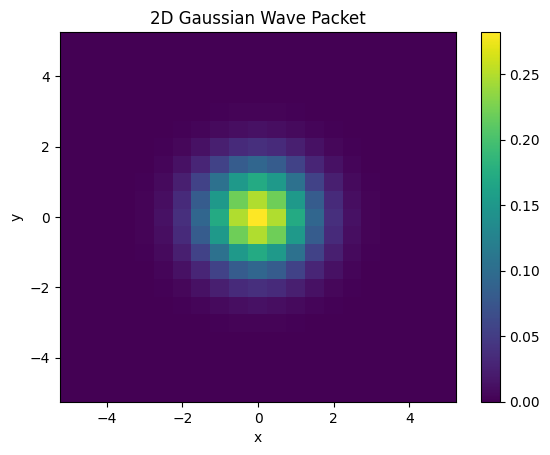

In [98]:
psi = psi0_2D(x0, y0, sigma_x, sigma_y, kx, ky)
# 2D plot
plt.pcolor(x, y, np.abs(psi))
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.title('2D Gaussian Wave Packet')
plt.show()

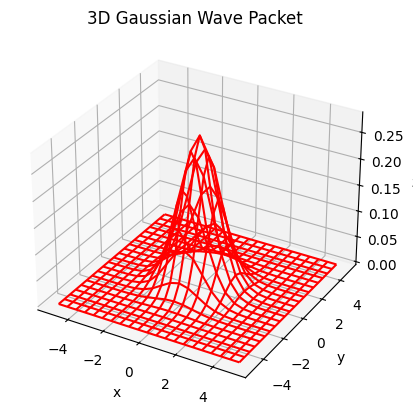

In [99]:
# 3D plot
ax = plt.axes(projection='3d')
ax.set_title('3D Gaussian Wave Packet')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title('3D Gaussian Wave Packet')
ax.plot_wireframe(x, y, np.abs(psi), color='red')
plt.show()

In [100]:
# parabolic potential
def V_2d_pp(k):
    V = np.zeros((N, N))
    for i in range(N):
        for j in range(N):
            V[i, j] = k * (x[i, j]**2 + y[i, j]**2)
    return V

# infinite square well potential


def V_2d():
    V = np.zeros((N, N))
    for i in range(N):
        for j in range(N):
            if (i == 0 or i == N - 1 or j == 0 or j == N - 1):
                V[i, j] = 1e10
    return V

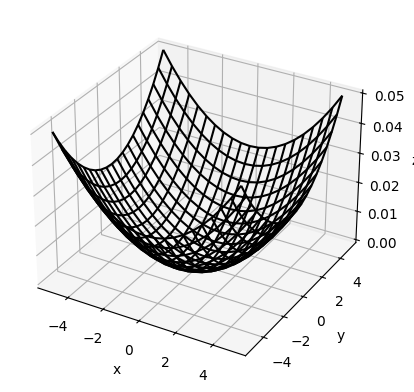

In [101]:
# 3D plot
ax = plt.axes(projection='3d')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.plot_wireframe(x, y, V_2d_pp(k)/100, color='black')
plt.show()

In [102]:
# euler algorithm for solving the Schrödinger equation
def euler(V, psi):
    laplacian = np.zeros((N, N), dtype=np.complex_)
    psi_next = np.zeros((N, N), dtype=np.complex_)
    for i in range(1, N - 1):
        for j in range(1, N - 1):
            laplacian[i, j] = (psi[i + 1, j] - 2 * psi[i, j] + psi[i - 1, j]) + \
                (psi[i, j + 1] - 2 * psi[i, j] + psi[i, j - 1])
            psi_next[i, j] = psi[i, j] - 1j * dt / \
                (2 * m * dx**2) * laplacian[i, j] + \
                1j * dt / hbar * V[i, j] * psi[i, j]
    return psi_next

In [103]:
# Crank-Nicholson algorithm for solving the Schrödinger equation
def crank_nicholson(V, psi):
    # reshape psi and V
    psi = psi.flatten()
    V = V.flatten()

    # Calculate the coefficients
    alpha = 1j * dt / (4 * dx**2)*(hbar**2 / (2 * m))

    # AX = MY
    for i in range(1, N**2):
        # Construct A
        A = np.diag(1 + 4*alpha + 0.5j*dt*V)  # diagonal
        A += np.diag(-alpha * np.ones(N**2 - 1), 1)  # upper diagonal
        A += np.diag(-alpha * np.ones(N**2 - 1), -1)  # lower diagonal
        A += np.diag(-alpha * np.ones((N-1)*N), N)  # upper diagonal
        A += np.diag(-alpha * np.ones((N-1)*N), -N)  # lower diagonal

        # Construct M
        M = np.diag(1 - 4*alpha - 0.5j*dt*V)
        M += np.diag(alpha * np.ones(N**2 - 1), 1)
        M += np.diag(alpha * np.ones(N**2 - 1), -1)
        M += np.diag(alpha * np.ones((N-1)*N), N)
        M += np.diag(alpha * np.ones((N-1)*N), -N)
    # Solve the linear system
    A = csc_matrix(A)
    psi = spsolve(A, np.dot(M, psi))
    psi = psi.reshape(N, N)
    return psi

In [104]:
def time_evolution(x0, y0, f):
    V = V_2d_pp(k)
    psi = psi0_2D(x0, y0)
    Psi = []
    t = 0.0
    while t < T:
        Psi.append((t, psi))
        psi = f(V, psi)
        t += dt
    return Psi


Psi_euler = time_evolution(x0, y0, euler)
Psi_crank_nicholson = time_evolution(x0, y0, crank_nicholson)

In [105]:
def fd_2d_time_evolution(V, psi):
    """finite difference algorithm for 2D Schrodinger equation"""
    psi_last = psi
    psi = crank_nicholson(V, psi_last)
    psi_next = np.zeros_like(psi)
    Psi = [(0.0, psi_last), (dt, psi)]
    alpha = dt / (2 * dx**2) ** (hbar**2 / (2 * m))
    t = 0.0
    while t < T:
        for i in range(len(psi)):
            for j in range(len(psi)):
                if i == 0 or i == len(psi) - 1 or j == 0 or j == len(psi) - 1:
                    psi_next[i][j] = 0
                else:
                    psi_next[i][j] = psi_last[i][j] - 2j * (4 * alpha + 0.5 * dt * V[i][j]) * psi[i][j] + 2j * alpha * (
                        psi[i+1][j] + psi[i-1][j] + psi[i][j+1] + psi[i][j-1])
        psi_last = psi.copy()
        psi = psi_next.copy()
        psi /= norm(psi)
        Psi.append((t + 2*dt, psi))
        t += dt

    return Psi


Psi_fd = fd_2d_time_evolution(V_2d(), psi0_2D(x0, y0))

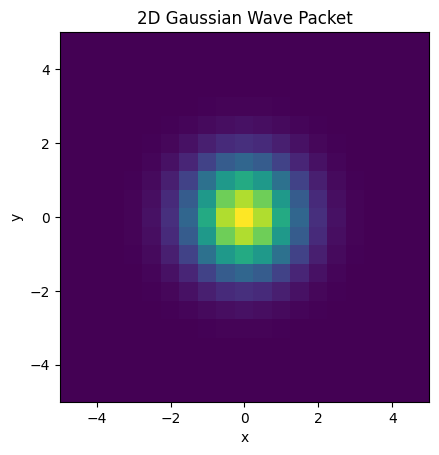

In [106]:
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt

Psi = Psi_fd

fig, ax = plt.subplots()

def animate(i):
    ax.clear()
    # heatmap
    psi = Psi[i][1]
    plt.pcolor(x, y, np.abs(psi))
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title('2D Gaussian Wave Packet')
    ax.set_aspect('equal')
    ax.set_xlim(-L/2, L/2)
    ax.set_ylim(-L/2, L/2)


ani = FuncAnimation(fig, animate, frames=len(Psi), interval=10)
# Save the animation
ani.save('2D_Gaussian_Wave_Packet.gif', writer='pillow')

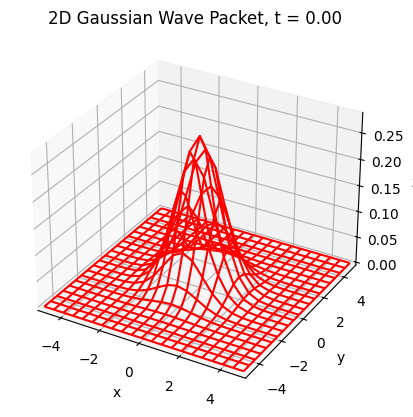

In [107]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

def animate_3d(i):
    ax.clear()
    psi = Psi[i][1]
    #ax.plot_surface(x, y, np.abs(psi), cmap='viridis', edgecolor='none')
    ax.plot_wireframe(x, y, np.abs(psi), color='red')
    #ax.plot_wireframe(x, y, V_2d_pp(k)/100, color='black', alpha=0.5)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.set_title(f'2D Gaussian Wave Packet, t = {Psi[i][0]:.2f}')
    ax.set_xlim(-L/2, L/2)
    ax.set_ylim(-L/2, L/2)
    ax.set_zlim(0, np.max(np.abs(Psi[0][1])))


ani_3d = FuncAnimation(fig, animate_3d, frames=len(Psi), interval=100)
# Save the animation
ani_3d.save('3D_Gaussian_Wave_Packet.gif', writer='pillow')

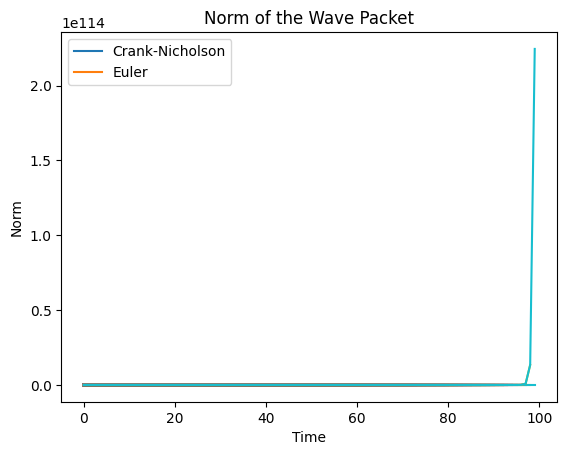

In [108]:
# make a plot of how the norm of the wave packet changes over time for the different algorithms
for i in [Psi_crank_nicholson, Psi_euler]:
    Psi = i
    norms = []
    for i in range(int(len(Psi)/2)):
        norms.append(norm(Psi[i][1]) - 1)
        plt.plot(norms)

plt.legend(['Crank-Nicholson', 'Euler'])
plt.xlabel('Time')
plt.ylabel('Norm')
plt.title('Norm of the Wave Packet')
plt.show()